In [1]:
import os
import tempfile

import anndata as ad
import muon
import numpy as np
import scanpy as sc
import seaborn as sns
import torch
import muon as mu
import pertpy as pt
import pandas as pd
import re
import torch
from lightning.pytorch import Trainer


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import scvi
print(scvi.__version__)
from scvi.model._scvi import SCVI


1.1.3


In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [4]:
# Load the .h5ad file
adata = ad.read_h5ad('/Users/ismail/thesis/K562 essential RNA protein.h5ad')

# Display the object
print(adata)


AnnData object with n_obs × n_vars = 310385 × 8563
    obs: 'batch', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'guide_id', 'percent_mito', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'disease', 'cancer', 'cell_line', 'sex', 'age', 'perturbation', 'organism', 'perturbation_type', 'tissue_type', 'ncounts', 'ngenes', 'nperts', 'percent_ribo'
    var: 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'ensembl_id', 'ncounts', 'ncells'


In [5]:
adata.obs

,batch,gene,gene_id,transcript,gene_transcript,guide_id,percent_mito,UMI_count,z_gemgroup_UMI,core_scale_factor,...,sex,age,perturbation,organism,perturbation_type,tissue_type,ncounts,ngenes,nperts,percent_ribo
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGAAATCCA-27,27,NAF1,ENSG00000145414,P1P2,5449_NAF1_P1P2_ENSG00000145414,NAF1_+_164087918.23-P1P2|NAF1_-_164087674.23-P1P2,0.112083,11438.0,0.013047,0.813253,...,Female,53,NAF1,human,CRISPR,cell_line,11324.0,3332,1,0.225362
AAACCCAAGAACTTCC-31,31,BUB1,ENSG00000169679,P1P2,935_BUB1_P1P2_ENSG00000169679,BUB1_-_111435363.23-P1P2|BUB1_-_111435372.23-P1P2,0.179895,5342.0,-1.522247,0.844107,...,Female,53,BUB1,human,CRISPR,cell_line,5257.0,2192,1,0.129732
AAACCCAAGAAGCCAC-34,34,UBL5,ENSG00000198258,P1P2,9534_UBL5_P1P2_ENSG00000198258,UBL5_-_9938639.23-P1P2|UBL5_+_9938801.23-P1P2,0.105287,17305.0,0.384157,1.091537,...,Female,53,UBL5,human,CRISPR,cell_line,17135.0,4002,1,0.236825
AAACCCAAGAATAGTC-43,43,C9orf16,ENSG00000171159,P1P2,1131_C9orf16_P1P2_ENSG00000171159,C9orf16_+_130922603.23-P1P2|C9orf16_+_13092264...,0.099359,30244.0,3.721912,0.948277,...,Female,53,C9orf16,human,CRISPR,cell_line,29717.0,5358,1,0.246828
AAACCCAAGACAGCGT-28,28,TIMM9,ENSG00000100575,P1P2,8927_TIMM9_P1P2_ENSG00000100575,TIMM9_-_58893843.23-P1P2|TIMM9_-_58893848.23-P1P2,0.137623,8407.0,-0.975371,0.868942,...,Female,53,TIMM9,human,CRISPR,cell_line,8261.0,2944,1,0.183392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCTGTCGTC-45,45,ATP6V1D,ENSG00000100554,P1P2,682_ATP6V1D_P1P2_ENSG00000100554,ATP6V1D_+_67826485.23-P1P2|ATP6V1D_+_67826497....,0.100272,18350.0,0.428227,1.115052,...,Female,53,ATP6V1D,human,CRISPR,cell_line,18044.0,4300,1,0.253547
TTTGTTGTCTGTCTCG-27,27,CNOT3,ENSG00000088038,P1P2,1718_CNOT3_P1P2_ENSG00000088038,CNOT3_+_54641532.23-P1P2|CNOT3_-_54641691.23-P1P2,0.093876,8671.0,-0.633593,0.813253,...,Female,53,CNOT3,human,CRISPR,cell_line,8510.0,3158,1,0.183196
TTTGTTGTCTGTGCGG-44,44,METTL3,ENSG00000165819,P1P2,5004_METTL3_P1P2_ENSG00000165819,METTL3_+_21979431.23-P1P2|METTL3_-_21979084.23...,0.107983,20568.0,1.054624,0.973352,...,Female,53,METTL3,human,CRISPR,cell_line,20355.0,4247,1,0.256595


In [6]:
adata.var

,chr,start,end,class,strand,length,in_matrix,mean,std,cv,fano,ensembl_id,ncounts,ncells
gene_name,,,,,,,,,,,,,,
LINC01409,chr1,778747,810065,gene_version10,+,31318,True,0.137594,0.380048,2.762105,1.049733,ENSG00000237491,42707.0,39082
LINC01128,chr1,825138,868202,gene_version9,+,43064,True,0.256720,0.520162,2.026184,1.053944,ENSG00000228794,79682.0,68732
NOC2L,chr1,944203,959309,gene_version11,-,15106,True,1.975144,1.707837,0.864665,1.476706,ENSG00000188976,613055.0,248759
KLHL17,chr1,960584,965719,gene_version14,+,5135,True,0.119593,0.353702,2.957540,1.046089,ENSG00000187961,37120.0,34277
HES4,chr1,998962,1000172,gene_version10,-,1210,True,0.249577,0.561933,2.251540,1.265214,ENSG00000188290,77465.0,62316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BX004987.1,GL000009.2,56140,58376,gene_version1,-,2236,True,0.241213,0.507266,2.102976,1.066768,ENSG00000278704,74869.0,64649
MAFIP,GL000194.1,53594,115055,gene_version1,-,61461,True,0.127525,0.361556,2.835168,1.025072,ENSG00000274847,39582.0,36731
AL354822.1,GL000218.1,51867,54893,gene_version1,-,3026,True,0.248814,0.516552,2.076062,1.072394,ENSG00000278384,77228.0,66416


In [7]:
perturbations = [
    'ANAPC15', 'ARGLU1', 'ATF6B1B2', 'BCR', 'BUB1', 'BUB3', 'CADM4', 'CDC27', 'CDK1', 
    'CHMP6', 'CPSF3', 'CSE1L', 'DHX15', 'DNAJC19']

# Subset the AnnData object
perturbated_adata = adata[adata.obs["perturbation"].isin(perturbations)].copy()
control_adata = adata[adata.obs["nperts"] == 0].copy()


In [8]:
perturbated_adata.obs["nperts"].value_counts()

nperts
1    6074
Name: count, dtype: int64

In [9]:
import anndata

combined_adata = anndata.concat([perturbated_adata, control_adata])
adata_ref = combined_adata.copy()


In [10]:
SCVI.setup_anndata(adata_ref, batch_key="batch")

In [11]:
# Initialize the Quasi SCVI model
trainer = Trainer(accelerator='gpu', devices=1) 

scvi_ref = SCVI(
    adata_ref,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

# Train the model
scvi_ref.train(max_epochs=400, plan_kwargs={"lr": 1e-4})

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|███████████████████████████████████| 400/400 [55:13<00:00,  7.85s/it, v_num=1, train_loss_step=8.62e+3, train_loss_epoch=8.75e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████| 400/400 [55:13<00:00,  8.28s/it, v_num=1, train_loss_step=8.62e+3, train_loss_epoch=8.75e+3]


In [12]:
scvi_ref.history["elbo_train"]
train_loss = scvi_ref.history["elbo_train"]
kl_divergence = scvi_ref.history["kl_local_train"]

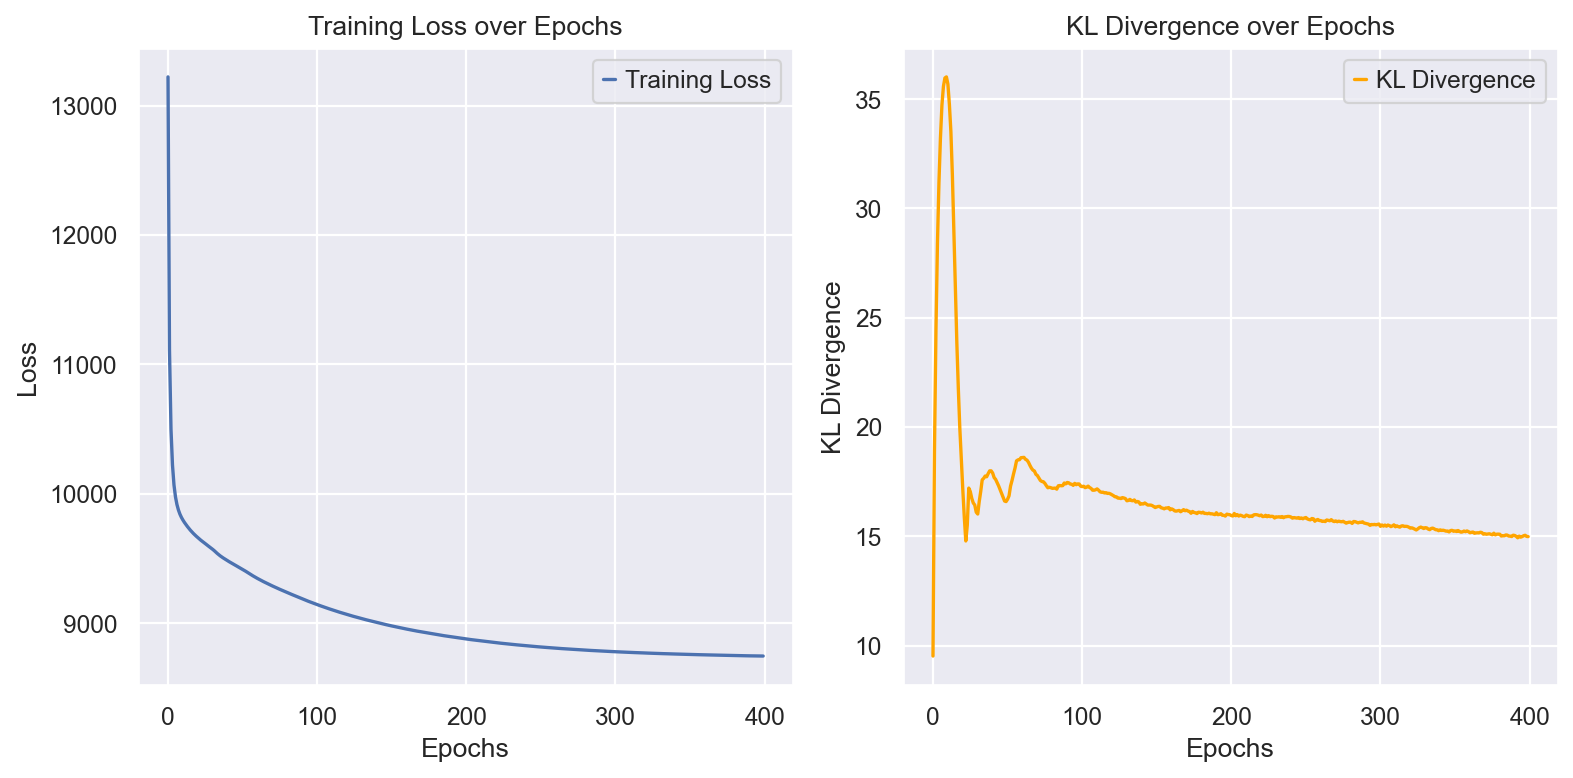

In [13]:
# Plot training loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot KL divergence
plt.subplot(1, 2, 2)
plt.plot(kl_divergence, label='KL Divergence', color='orange')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
SCVI_LATENT_KEY = "X_scVI"

adata_ref.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

/var/folders/3k/yfw07yqn6nbdwjkxhf022b2m0000gn/T/ipykernel_17096/3423007261.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_ref)


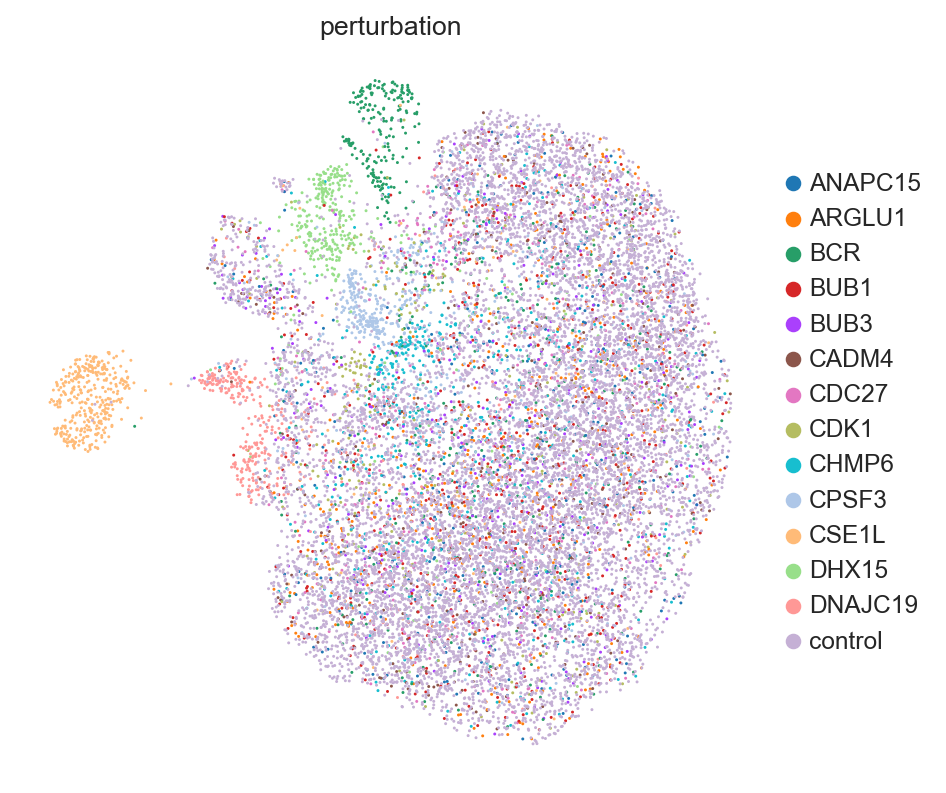

In [15]:
sc.pl.umap(
    adata_ref,
    color=[ "perturbation"],
    frameon=False,
    ncols=1,
)

Output()

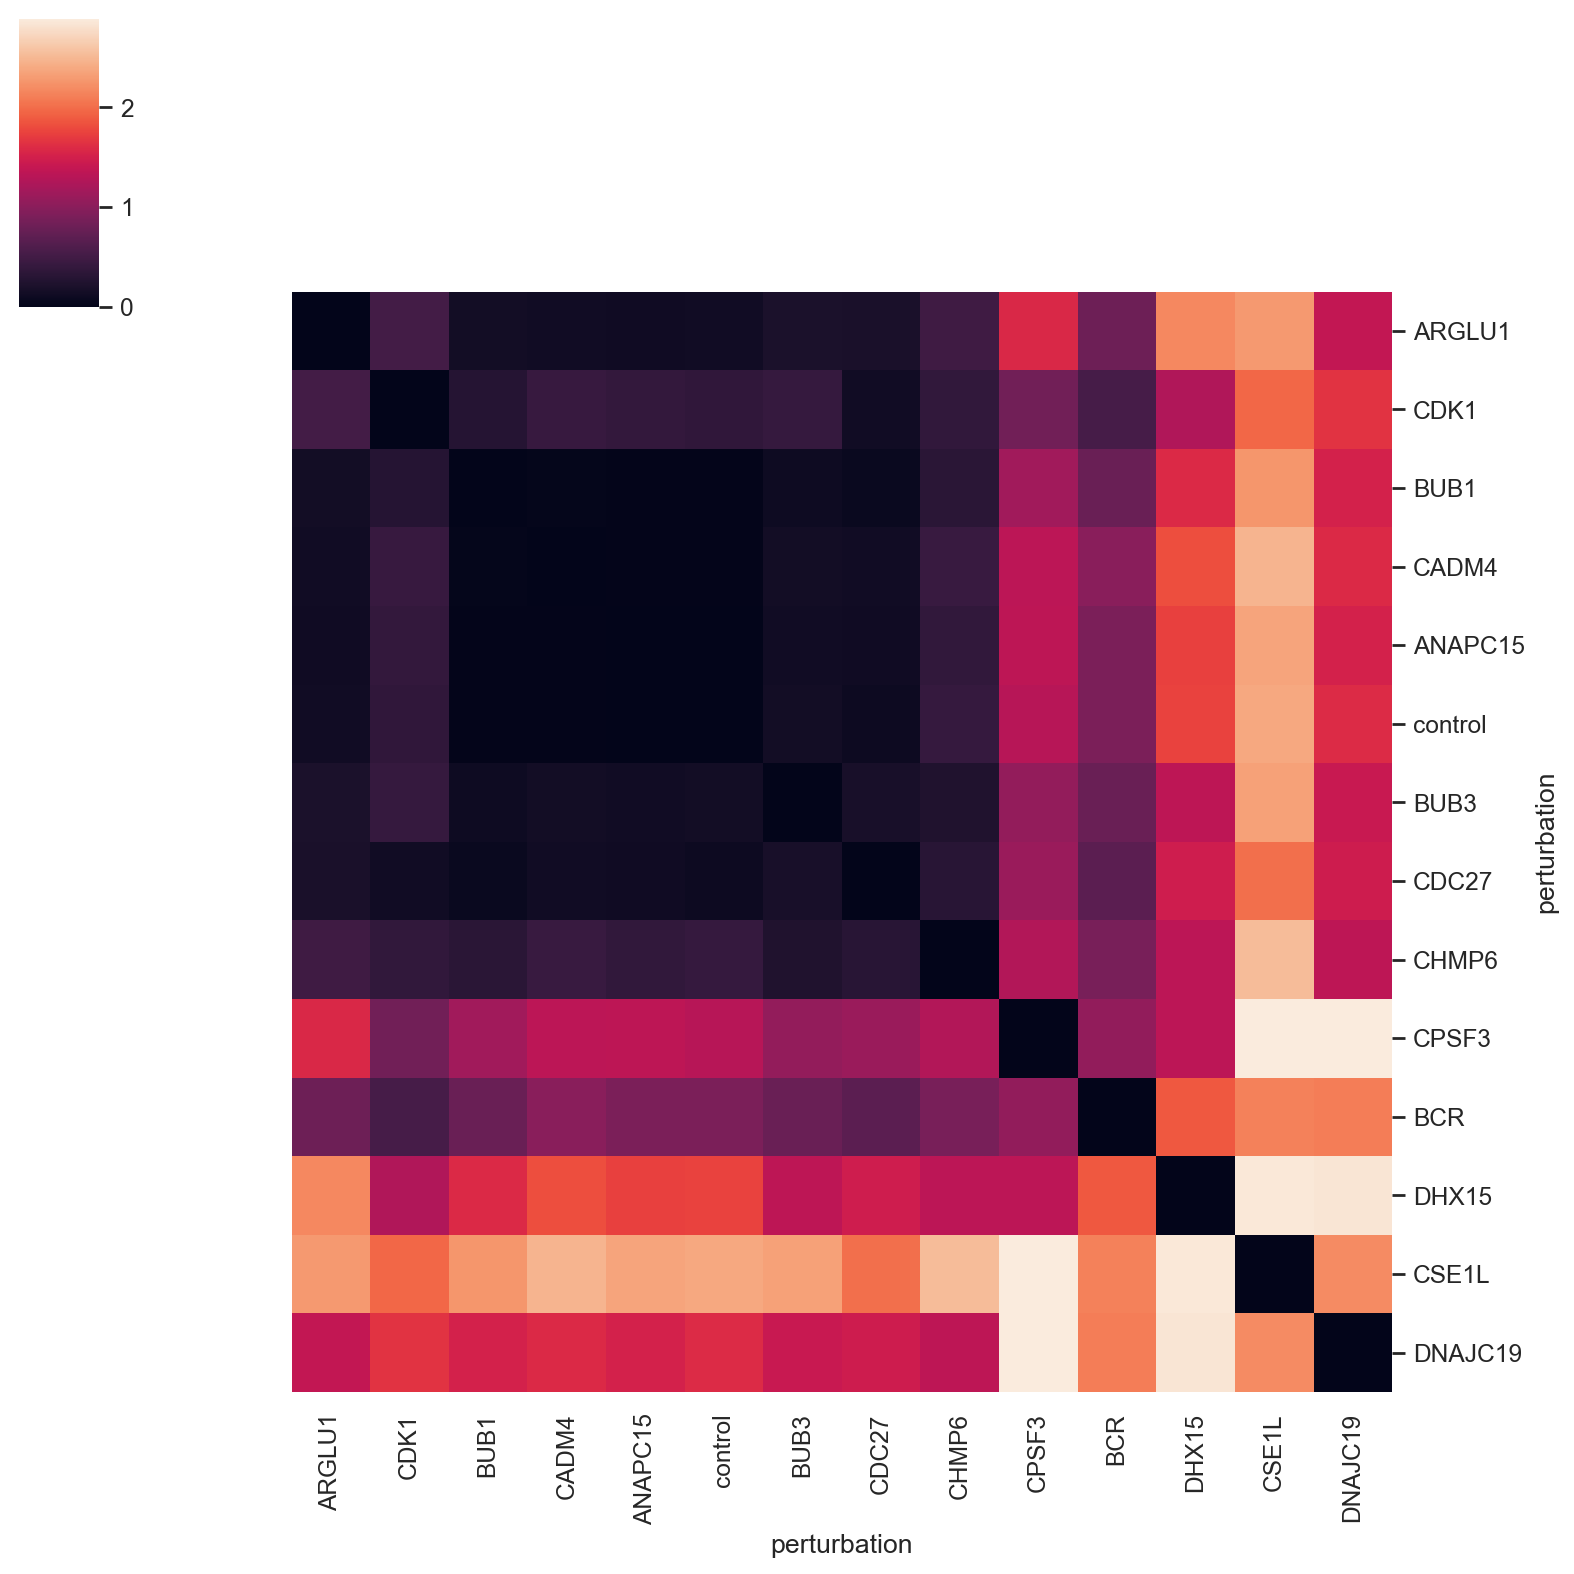

In [16]:
import matplotlib.pyplot as plt
from seaborn import clustermap
order = ['ARGLU1', 'CDK1', 'BUB1', 'CADM4', 'ANAPC15', 'control', 'BUB3', 'CDC27', 'CHMP6', 'CPSF3', 'BCR', 'DHX15', 'CSE1L', 'DNAJC19']

distance = pt.tl.Distance("edistance", obsm_key=SCVI_LATENT_KEY)
df = distance.pairwise(adata_ref, groupby="perturbation")
df_reordered = df.loc[order, order]

# Plot the clustermap
sns.clustermap(df_reordered, robust=True, figsize=(10, 10), row_cluster=False, col_cluster=False)
plt.show()